# Pothole Image Classification with CNNs

### Importing Libraries


In [1]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import cv2
import numpy as np
import seaborn as sns
import gradio as gr
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, Xception,VGG19,DenseNet169, ResNet50V2,DenseNet201,InceptionV3,InceptionResNetV2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential, Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import (
    Input, Flatten, Dense, Dropout, Reshape, Add, GlobalAveragePooling1D, LayerNormalization,GlobalAveragePooling2D
)
from tensorflow.keras.layers import MultiHeadAttention
import warnings
warnings.filterwarnings('ignore')


c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Defining Paths to Image Data

In [ ]:
normal_path = 'Data/normal'
potholes_path = 'Data/potholes'
bump_path='Data/bump'


### Function for Displaying Sample Images

In [ ]:
def show_samples(image_paths, title):
    num_images = min(len(image_paths), 5) 
    if num_images == 0:
        print(f"No images found for {title}")
        return
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(image_paths[:num_images]):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

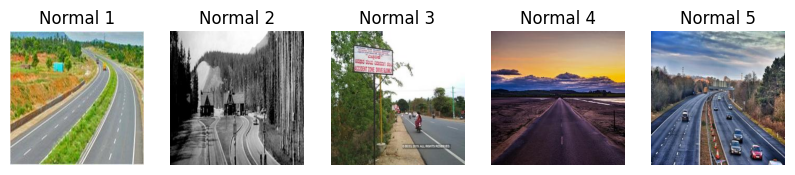

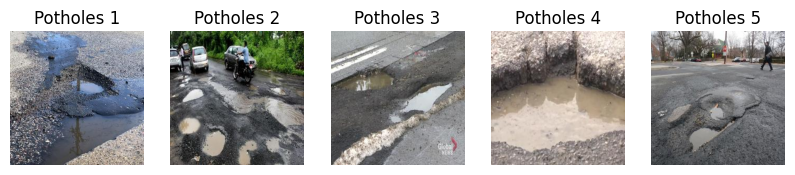

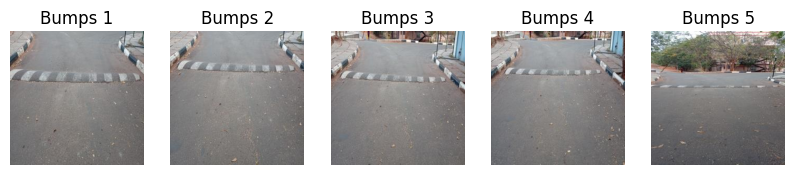

In [ ]:
normal_images = glob(os.path.join(normal_path, '*.jpg'))
potholes_images = glob(os.path.join(potholes_path, '*.jpg'))
bumps_images = glob(os.path.join(bump_path, '*.jpg'))

show_samples(normal_images, 'Normal')
show_samples(potholes_images, 'Potholes')
show_samples(bumps_images, 'Bumps')

### Loading and Preprocessing Data

In [ ]:
IMG_SIZE = (256, 256)
def preprocess_image(img):
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0  
    return img

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0 
    return img

In [ ]:
def load_data():
    images = []
    labels = []
    normal_images = glob(os.path.join(normal_path, '*.jpg'))
    for img_path in normal_images:
        print(f"Reading image: {img_path}")
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            labels.append(0) 

    potholes_images = glob(os.path.join(potholes_path, '*.jpg'))
    for img_path in potholes_images:
        print(f"Reading image: {img_path}")
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            labels.append(1)  

    bumps_images = glob(os.path.join(bump_path, '*.jpg'))
    for img_path in bumps_images:
        print(f"Reading image: {img_path}")
        img = preprocess_image(img_path)
        if img is not None:
            images.append(img)
            labels.append(2) 

    return np.array(images), np.array(labels)


images, labels = load_data()


Reading image: Data/normal\1.jpg
Reading image: Data/normal\10.jpg
Reading image: Data/normal\100.jpg
Reading image: Data/normal\101.jpg
Reading image: Data/normal\102.jpg
Reading image: Data/normal\103.jpg
Reading image: Data/normal\104.jpg
Reading image: Data/normal\105.jpg
Reading image: Data/normal\106.jpg
Reading image: Data/normal\107.jpg
Reading image: Data/normal\108.jpg
Reading image: Data/normal\109.jpg
Reading image: Data/normal\11.jpg
Reading image: Data/normal\110.jpg
Reading image: Data/normal\111.jpg
Reading image: Data/normal\112.jpg
Reading image: Data/normal\113.jpg
Reading image: Data/normal\114.jpg
Reading image: Data/normal\115.jpg
Reading image: Data/normal\116.jpg
Reading image: Data/normal\117.jpg
Reading image: Data/normal\118.jpg
Reading image: Data/normal\119.jpg
Reading image: Data/normal\12.jpg
Reading image: Data/normal\120.jpg
Reading image: Data/normal\121.jpg
Reading image: Data/normal\122.jpg
Reading image: Data/normal\123.jpg
Reading image: Data/norma

### Preparing Data for Training and Validation


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

### Data Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
)

val_datagen = ImageDataGenerator() 

In [ ]:
train_datagen.fit(X_train)
val_datagen.fit(X_val)

### Data Visualization: Class Distribution

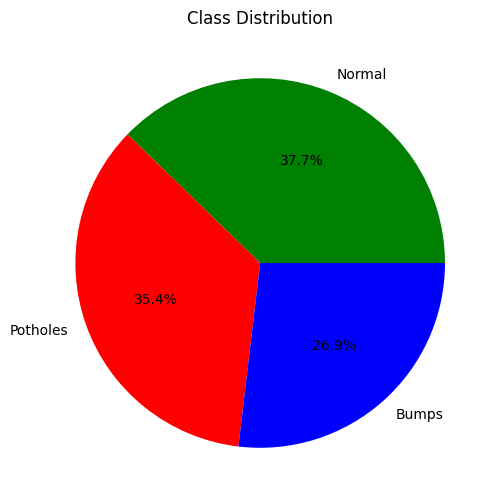

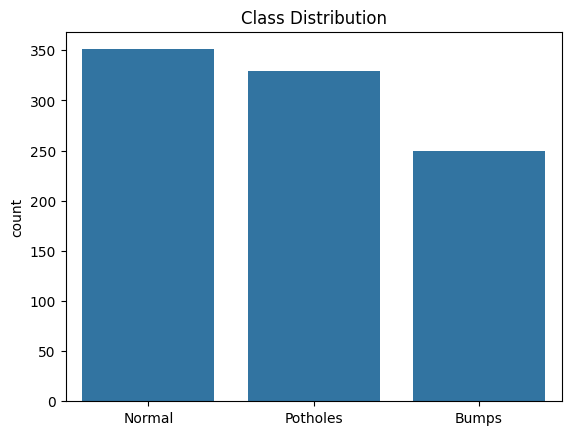

In [ ]:
plt.figure(figsize=(6, 6))
plt.pie([np.sum(labels == 0), np.sum(labels == 1), np.sum(labels == 2)], 
        labels=['Normal', 'Potholes', 'Bumps'], autopct='%1.1f%%', 
        colors=['green', 'red', 'blue'])
plt.title('Class Distribution')
plt.show()
sns.countplot(x=labels)
plt.title('Class Distribution')
plt.xticks([0, 1, 2], ['Normal', 'Potholes', 'Bumps'])
plt.show()


In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

## **Custom CNN**

In [ ]:
baseline_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3),kernel_regularizer=l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=l2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  
])

In [ ]:
baseline_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = baseline_cnn.fit(train_datagen.flow(X_train, y_train, batch_size=32),epochs=25,validation_data=val_datagen.flow(X_val, y_val))

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.4307 - loss: 1.9688 - val_accuracy: 0.7419 - val_loss: 0.6776
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7140 - loss: 0.6951 - val_accuracy: 0.7849 - val_loss: 0.7434
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7481 - loss: 0.6348 - val_accuracy: 0.7903 - val_loss: 0.4650
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.8229 - loss: 0.4948 - val_accuracy: 0.7849 - val_loss: 0.4753
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 55s 3s/step - accuracy: 0.7961 - loss: 0.5256 - val_accuracy: 0.7688 - val_loss: 0.4797
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.7992 - loss: 0.5282 - val_accuracy: 0.7957 - val_loss: 0.5626
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.8225 - loss: 0.4778 - val_accuracy: 0.8065 - val_loss: 0.4194
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 70s 4s/step - accuracy: 0.8386 - loss: 0.4275 - val_accuracy: 0.7473 - val_loss:

In [ ]:
train_loss, train_accuracy = baseline_cnn.evaluate(X_train, y_train)
test_loss, test_accuracy = baseline_cnn.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
model_save_path = 'pothole_detection_model.h5'
baseline_cnn.save(model_save_path)
print(f"Model saved to {model_save_path}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 787ms/step - accuracy: 0.9450 - loss: 0.1611
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 642ms/step - accuracy: 0.9049 - loss: 0.2665


Training Accuracy: 94.61%
Test Accuracy: 91.40%
Model saved to pothole_detection_model.h5


In [ ]:
loaded_model = load_model('pothole_detection_model.h5')

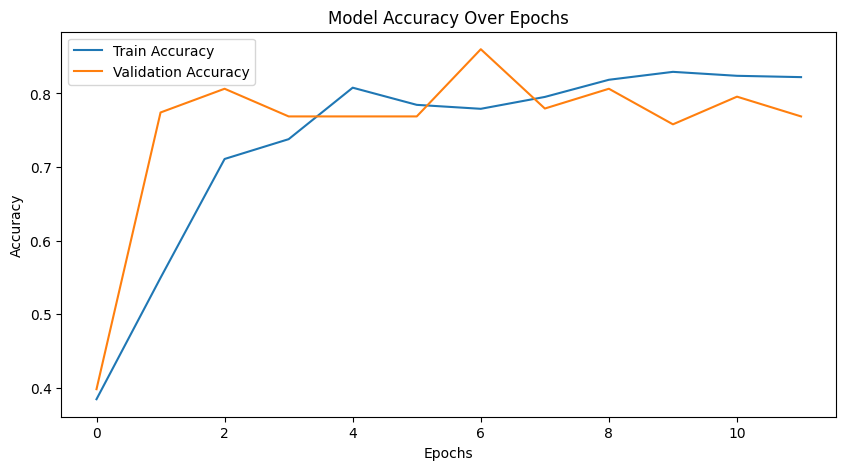

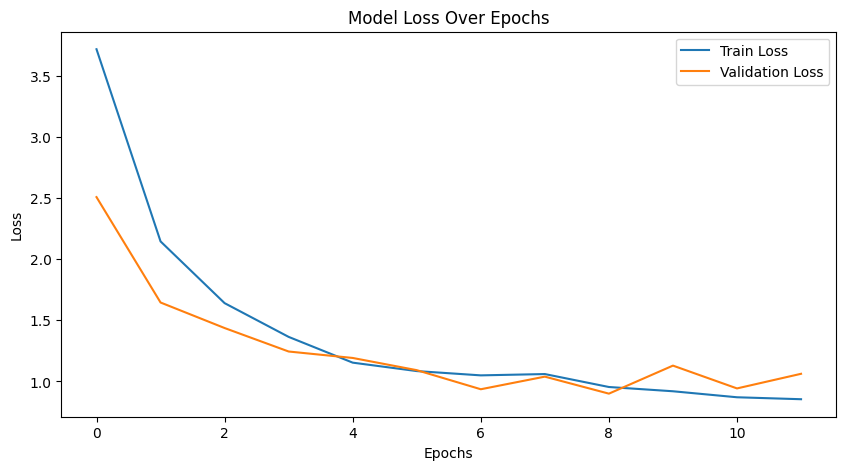

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = loaded_model.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 344ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.85      0.91        68
    Potholes       0.87      0.94      0.90        69
       Bumps       0.92      0.96      0.94        49

    accuracy                           0.91       186
   macro avg       0.92      0.92      0.92       186
weighted avg       0.92      0.91      0.91       186



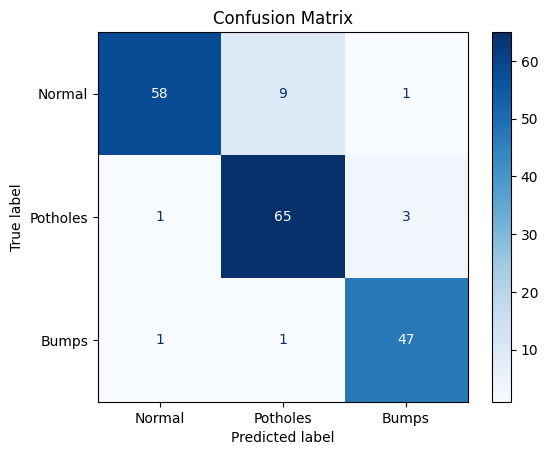

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## **VGG16**

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation='relu')(x)
x = Dense(3, activation='softmax')(x)  

In [ ]:
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),validation_data=val_datagen.flow(X_val, y_val),epochs=25,callbacks=[early_stopping])

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 270s 15s/step - accuracy: 0.3654 - loss: 1.0754 - val_accuracy: 0.7527 - val_loss: 0.8148
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 269s 15s/step - accuracy: 0.7984 - loss: 0.7977 - val_accuracy: 0.7849 - val_loss: 0.6472
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 258s 14s/step - accuracy: 0.8401 - loss: 0.6183 - val_accuracy: 0.8602 - val_loss: 0.5205
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 284s 16s/step - accuracy: 0.8323 - loss: 0.5320 - val_accuracy: 0.8925 - val_loss: 0.4250
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 299s 17s/step - accuracy: 0.8392 - loss: 0.4882 - val_accuracy: 0.8925 - val_loss: 0.3779
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 308s 17s/step - accuracy: 0.9034 - loss: 0.3788 - val_accuracy: 0.8925 - val_loss: 0.3797
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 355s 20s/step - accuracy: 0.8963 - loss: 0.3475 - val_accuracy: 0.9140 - val_loss: 0.3265
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 368s 21s/step - accuracy: 0.9019 - loss: 0.3340 - val_accuracy: 0.

In [ ]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,912,843 (56.89 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 132,104 (516.04 KB)

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy VGG16: {train_accuracy*100:.2f}%")
print(f"Test Accuracy VGG16: {test_accuracy*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 240s 13s/step - accuracy: 0.9400 - loss: 0.2058
6/6 ━━━━━━━━━━━━━━━━━━━━ 102s 18s/step - accuracy: 0.9532 - loss: 0.1341
Training Accuracy VGG16: 95.87%
Test Accuracy VGG16: 94.62%


In [ ]:
model_save_path = 'vgg16.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to vgg16.h5


In [ ]:
loaded_modelVGG16 = load_model('vgg16.h5')

In [ ]:
y_pred_probs = loaded_modelVGG16.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  
print("Classification Report VGG16:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 115s 20s/step
Classification Report VGG16:
              precision    recall  f1-score   support

      Normal       0.94      0.96      0.95        68
    Potholes       0.94      0.97      0.96        69
       Bumps       1.00      0.94      0.97        49

    accuracy                           0.96       186
   macro avg       0.96      0.96      0.96       186
weighted avg       0.96      0.96      0.96       186



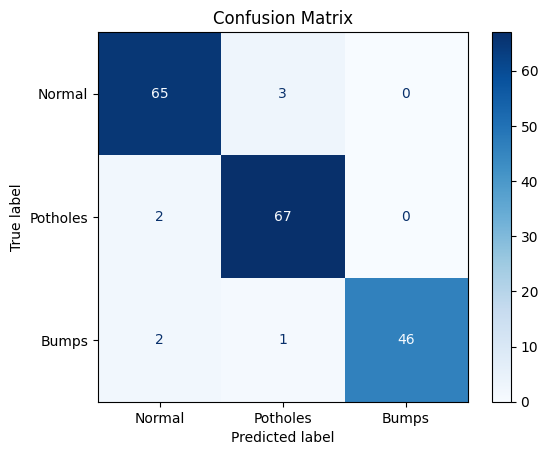

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

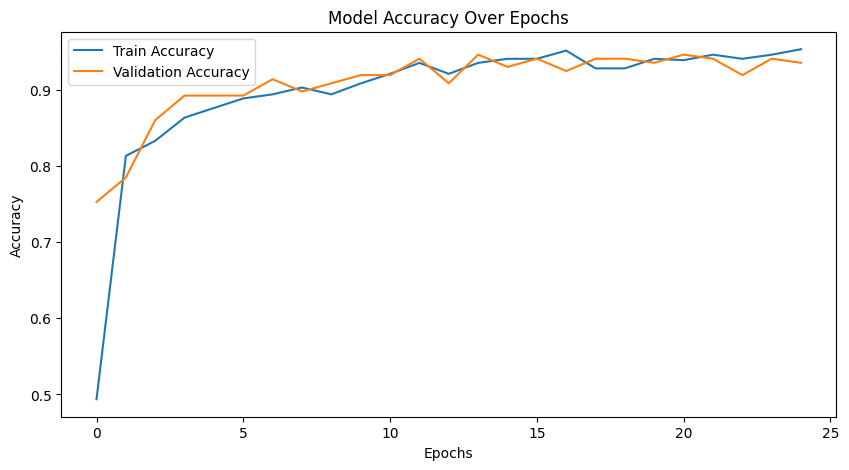

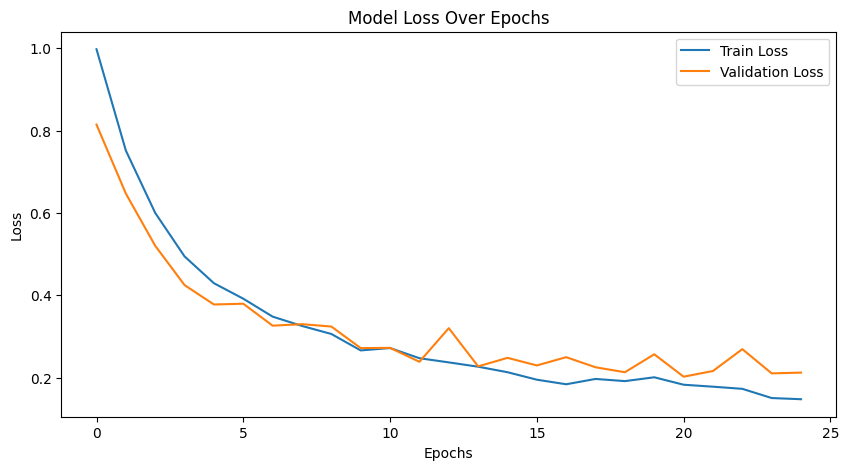

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **VGG19**

In [ ]:
def build_vgg19_model(input_shape, num_classes):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False 

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

In [ ]:
input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
model = build_vgg19_model(input_shape, 3)
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [ ]:
history = model.fit(train_datagen.flow(X_train, y_train, batch_size=32),validation_data=val_datagen.flow(X_val, y_val),epochs=25,callbacks=[early_stopping])

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 467s 26s/step - accuracy: 0.4100 - loss: 1.2201 - val_accuracy: 0.7849 - val_loss: 0.8283
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 399s 23s/step - accuracy: 0.6132 - loss: 0.8782 - val_accuracy: 0.8495 - val_loss: 0.6601
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 337s 19s/step - accuracy: 0.7467 - loss: 0.7141 - val_accuracy: 0.8387 - val_loss: 0.5760
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 374s 21s/step - accuracy: 0.7839 - loss: 0.6056 - val_accuracy: 0.8602 - val_loss: 0.4788
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 334s 19s/step - accuracy: 0.8348 - loss: 0.5246 - val_accuracy: 0.8602 - val_loss: 0.4257
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 331s 19s/step - accuracy: 0.8861 - loss: 0.4432 - val_accuracy: 0.8763 - val_loss: 0.3851
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 330s 19s/step - accuracy: 0.8879 - loss: 0.4103 - val_accuracy: 0.8925 - val_loss: 0.3552
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 334s 19s/step - accuracy: 0.8675 - loss: 0.4033 - val_accuracy: 0.

In [ ]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Training Accuracy VGG19:{train_accuracy*100:.2f}%")
print(f"Test Accuracy VGG19: {test_accuracy*100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 307s 17s/step - accuracy: 0.9233 - loss: 0.2133
6/6 ━━━━━━━━━━━━━━━━━━━━ 90s 15s/step - accuracy: 0.9287 - loss: 0.2401
Training Accuracy VGG1992.65%
Test Accuracy VGG19: 91.94%


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,420,683 (77.90 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 264,200 (1.01 MB)

In [ ]:
model.save('vgg19_model.h5')

In [ ]:
loaded_vgg19 = load_model('vgg19_model.h5')

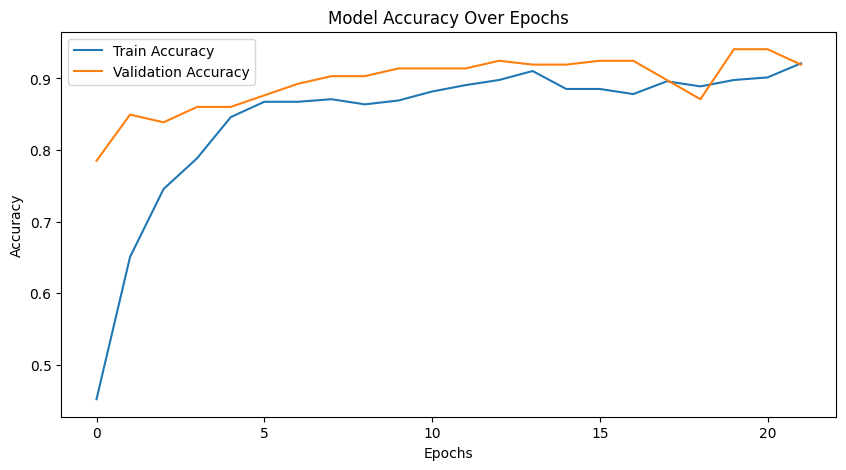

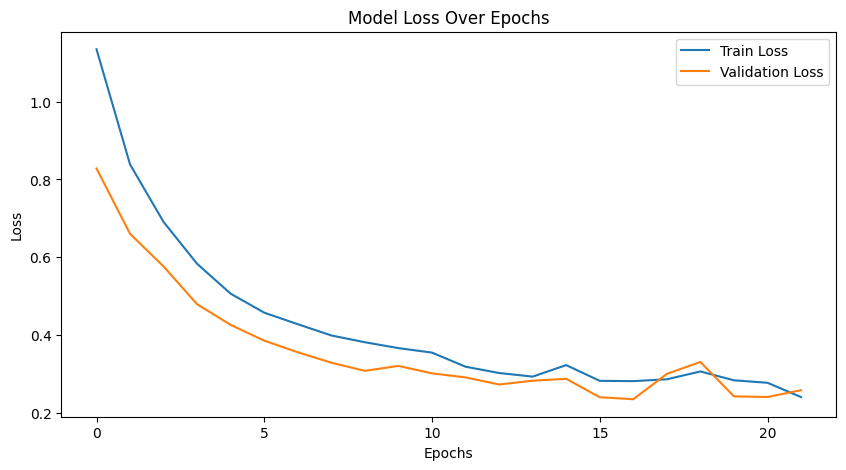

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = loaded_vgg19.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  
print("Classification Report VGG19:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 97s 16s/step
Classification Report VGG19:
              precision    recall  f1-score   support

      Normal       0.91      0.88      0.90        68
    Potholes       0.90      0.94      0.92        69
       Bumps       0.96      0.94      0.95        49

    accuracy                           0.92       186
   macro avg       0.92      0.92      0.92       186
weighted avg       0.92      0.92      0.92       186



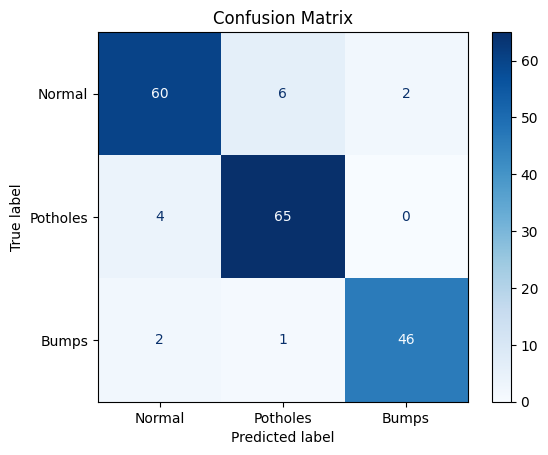

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## **DenseNet169**

In [ ]:
num_classes = len(np.unique(np.argmax(y_train, axis=1)))
input_shape = X_train.shape[1:] 
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
batch_size = 32
epochs = 25

In [ ]:
history_fine_tune = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),validation_data=val_datagen.flow(X_val,y_val),
epochs=epochs,callbacks=[early_stopping])

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.5293 - loss: 11.9931 - val_accuracy: 0.8925 - val_loss: 1.7504
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7994 - loss: 3.2932 - val_accuracy: 0.8441 - val_loss: 1.5560
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7893 - loss: 2.4141 - val_accuracy: 0.9409 - val_loss: 0.8847
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8536 - loss: 1.1028 - val_accuracy: 0.9032 - val_loss: 0.7387
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8811 - loss: 0.8214 - val_accuracy: 0.9194 - val_loss: 0.5581
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9002 - loss: 0.5159 - val_accuracy: 0.9409 - val_loss: 0.5431
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9045 - loss: 0.5994 - val_accuracy: 0.9301 - val_loss: 0.3965
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9134 - loss: 0.3168 - val_accuracy: 0.9140 - val_loss

In [ ]:
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_fine_tune = model.fit(train_datagen.flow(X_train, y_train, batch_size=batch_size),validation_data=val_datagen.flow(X_val,y_val),
    epochs=epochs,callbacks=[early_stopping])

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.8957 - loss: 0.6306 - val_accuracy: 0.9409 - val_loss: 0.5250
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9328 - loss: 0.4503 - val_accuracy: 0.9516 - val_loss: 0.3575
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8937 - loss: 0.6838 - val_accuracy: 0.9409 - val_loss: 0.3192
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9028 - loss: 0.3883 - val_accuracy: 0.9355 - val_loss: 0.3052
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9211 - loss: 0.2977 - val_accuracy: 0.9247 - val_loss: 0.3333
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9309 - loss: 0.3287 - val_accuracy: 0.9247 - val_loss: 0.4558
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9281 - loss: 0.2369 - val_accuracy: 0.9355 - val_loss: 0.2936
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9289 - loss: 0.2091 - val_accuracy: 0.9301 - val_loss:

In [ ]:
test_loss, test_accuracy = model.evaluate(val_datagen.flow(X_test, y_test, batch_size=batch_size))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9685 - loss: 0.2350
Test Loss: 0.17816613614559174
Test Accuracy: 0.9731183052062988


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet169 (Functional)             │ (None, 8, 8, 1664)          │      12,642,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 106496)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      27,263,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 94,612,811 (360.92 MB)

 Trainable params: 27,336,707 (104.28 MB)

 Non-trainable params: 12,602,688 (48.08 MB)

 Optimizer params: 54,673,416 (208.56 MB)

In [ ]:
model.save('densenet169_model(.973)(1).keras')

In [ ]:
loaded_modelInceptionResNetV2 = load_model('densenet169_model(.973)(1).keras')

In [ ]:
y_pred_probs = loaded_modelInceptionResNetV2.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print("Classification Report DenseNet169:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step
Classification Report DenseNet169:
              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96        68
    Potholes       0.97      0.99      0.98        69
       Bumps       0.98      0.98      0.98        49

    accuracy                           0.97       186
   macro avg       0.97      0.97      0.97       186
weighted avg       0.97      0.97      0.97       186



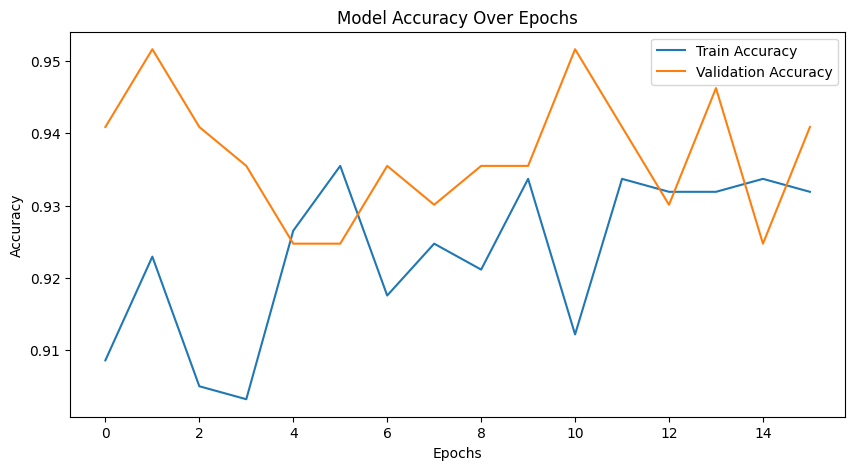

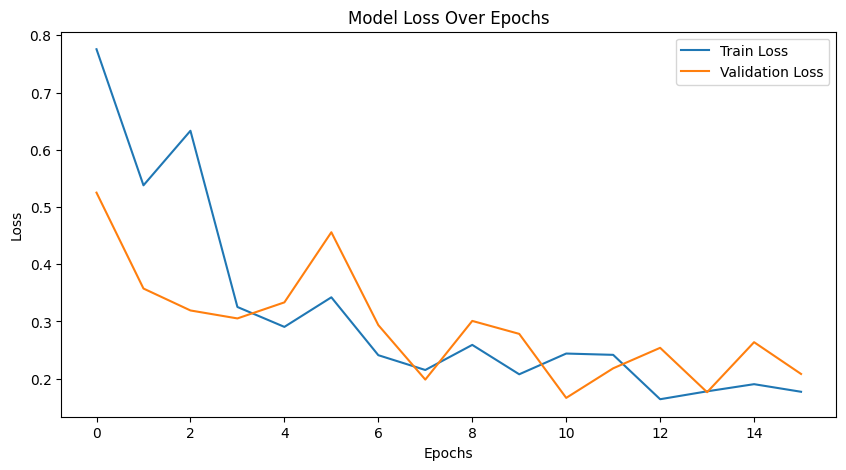

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **DenseNet201**

In [ ]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 38s 1us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  
x = Dense(128, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
densenet_model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
densenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',  patience=5,restore_best_weights=True )

In [ ]:
history = densenet_model.fit(train_datagen.flow(X_train, y_train, batch_size=32),epochs=25,validation_data=val_datagen.flow(X_val, y_val),callbacks=[early_stopping])


Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 157s 8s/step - accuracy: 0.8793 - loss: 0.3947 - val_accuracy: 0.8925 - val_loss: 0.2633
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.8494 - loss: 0.3767 - val_accuracy: 0.9301 - val_loss: 0.2037
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 134s 7s/step - accuracy: 0.8870 - loss: 0.2532 - val_accuracy: 0.9409 - val_loss: 0.1635
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.9040 - loss: 0.2474 - val_accuracy: 0.9409 - val_loss: 0.1851
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.9061 - loss: 0.2255 - val_accuracy: 0.9409 - val_loss: 0.1853
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 161s 9s/step - accuracy: 0.9299 - loss: 0.2302 - val_accuracy: 0.9194 - val_loss: 0.2141
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 167s 9s/step - accuracy: 0.8989 - loss: 0.2321 - val_accuracy: 0.9301 - val_loss: 0.1866
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 144s 8s/step - accuracy: 0.9291 - loss: 0.2063 - val_accuracy: 0.9301 - v

In [ ]:
train_loss, train_accuracy = densenet_model.evaluate(X_train, y_train)
test_loss, test_accuracy = densenet_model.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 106s 5s/step - accuracy: 0.9947 - loss: 0.0458
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 5s/step - accuracy: 0.9731 - loss: 0.0832


In [ ]:
print(f"Training Accuracy(DenseNet201): {train_accuracy*100:.2f}%")
print(f"Test Accuracy(DenseNet201): {test_accuracy*100:.2f}%")

Training Accuracy(DenseNet201): 99.10%
Test Accuracy(DenseNet201): 97.31%


In [ ]:
model_save_path = 'densenet_pothole_detection_model.h5'
densenet_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to densenet_pothole_detection_model.h5


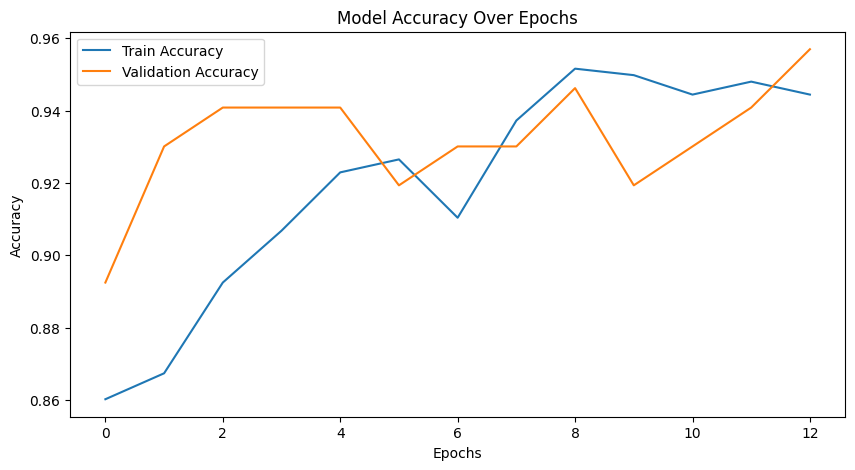

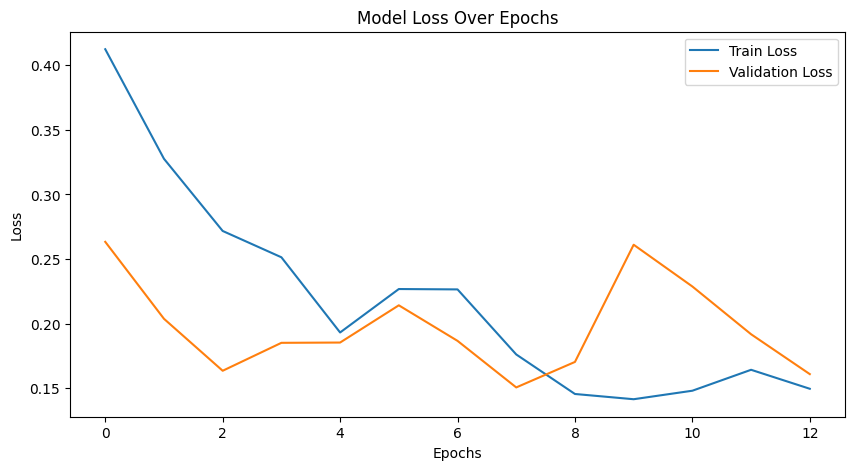

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_probs = densenet_model.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  

6/6 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step


Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97        68
    Potholes       0.95      1.00      0.97        69
       Bumps       1.00      0.96      0.98        49

    accuracy                           0.97       186
   macro avg       0.98      0.97      0.97       186
weighted avg       0.97      0.97      0.97       186



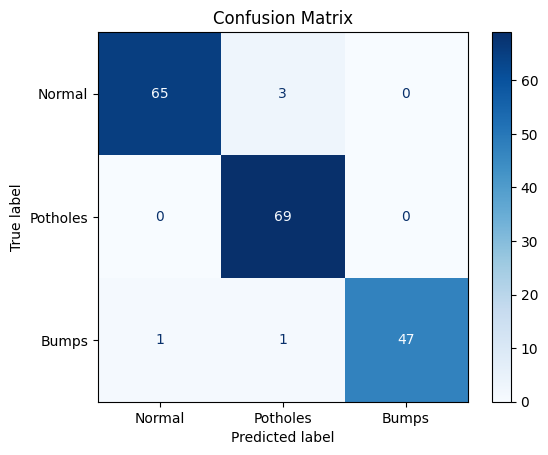

In [ ]:
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## **Xception**

In [ ]:
Xception_base_model = Xception(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

for layer in Xception_base_model.layers:
    layer.trainable = False

In [ ]:
x = Xception_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

Xception_model = Model(inputs=Xception_base_model.input, outputs=x)
Xception_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = Xception_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
18/18 [==============================] - 46s 2s/step - loss: 0.6570 - accuracy: 0.7294 - val_loss: 0.3386 - val_accuracy: 0.8763 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 43s 2s/step - loss: 0.3030 - accuracy: 0.8889 - val_loss: 0.2396 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 42s 2s/step - loss: 0.2004 - accuracy: 0.9319 - val_loss: 0.2175 - val_accuracy: 0.9409 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 42s 2s/step - loss: 0.1964 - accuracy: 0.9265 - val_loss: 0.2244 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 44s 2s/step - loss: 0.1750 - accuracy: 0.9391 - val_loss: 0.2167 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 44s 2s/step - loss: 0.1395 - accuracy: 0.9642 - val_loss: 0.2344 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 62s 4s/step - loss: 0.1182 - a

In [ ]:
for layer in Xception_base_model.layers[-10:]:
    layer.trainable = True

Xception_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

Xception_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
18/18 [==============================] - 56s 3s/step - loss: 0.3045 - accuracy: 0.9086 - val_loss: 1.0501 - val_accuracy: 0.8280 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 50s 3s/step - loss: 0.1373 - accuracy: 0.9552 - val_loss: 0.2370 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 84s 5s/step - loss: 0.0628 - accuracy: 0.9731 - val_loss: 0.3638 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 94s 5s/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.1401 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 80s 4s/step - loss: 0.0608 - accuracy: 0.9821 - val_loss: 0.1466 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 79s 4s/step - loss: 0.0624 - accuracy: 0.9803 - val_loss: 1.0540 - val_accuracy: 0.7849 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 77s 4s/step - loss: 0.0437 - a

In [ ]:
train_loss, train_accuracy = Xception_model.evaluate(train_datagen.flow(X_train, y_train))
test_loss, test_accuracy = Xception_model.evaluate(val_datagen.flow(X_test, y_test))

print(f"Training Accuracy Xception: {train_accuracy*100:.2f}%")
print(f"Test Accuracy Xception: {test_accuracy*100:.2f}%")

Training Accuracy Xception: 99.10%
Test Accuracy Xception: 96.24%


In [ ]:
Xception_model.save("Xception.keras")

In [ ]:
loaded_model = load_model("Xception.keras")

In [ ]:
y_pred_probs = loaded_model.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 [==============================] - 11s 2s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.99      0.96        68
    Potholes       0.99      0.96      0.97        69
       Bumps       0.96      0.94      0.95        49

    accuracy                           0.96       186
   macro avg       0.96      0.96      0.96       186
weighted avg       0.96      0.96      0.96       186



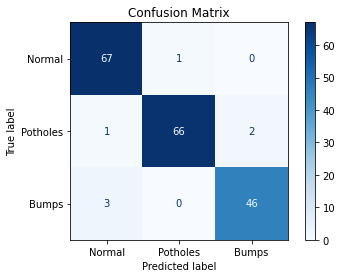

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

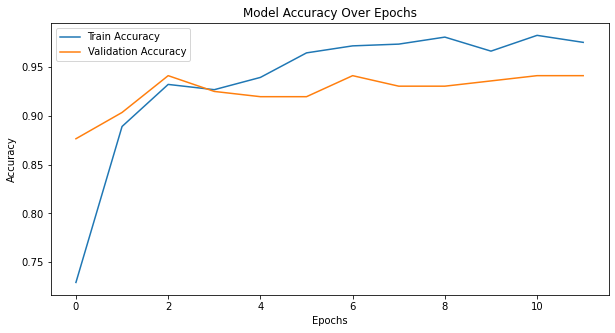

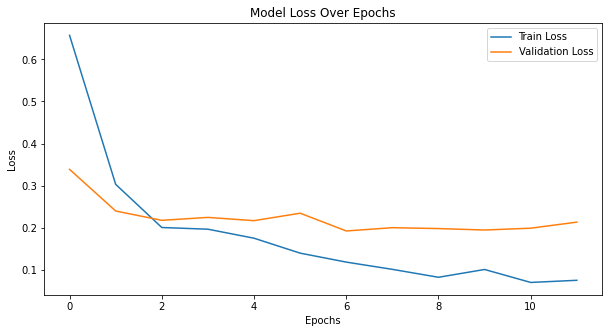

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **InceptionV3**

In [ ]:
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
18/18 [==============================] - 32s 1s/step - loss: 0.7707 - accuracy: 0.6703 - val_loss: 0.4346 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 30s 2s/step - loss: 0.3801 - accuracy: 0.8495 - val_loss: 0.2636 - val_accuracy: 0.9140 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 29s 2s/step - loss: 0.2548 - accuracy: 0.9140 - val_loss: 0.2832 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 26s 1s/step - loss: 0.2111 - accuracy: 0.9427 - val_loss: 0.2436 - val_accuracy: 0.9355 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 30s 2s/step - loss: 0.1861 - accuracy: 0.9462 - val_loss: 0.3383 - val_accuracy: 0.8710 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 26s 1s/step - loss: 0.1580 - accuracy: 0.9462 - val_loss: 0.2910 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 26s 1s/step - loss: 0.1528 - a

In [ ]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
18/18 [==============================] - 39s 2s/step - loss: 0.1706 - accuracy: 0.9427 - val_loss: 0.2452 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 26s 1s/step - loss: 0.1569 - accuracy: 0.9444 - val_loss: 0.2726 - val_accuracy: 0.9086 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 25s 1s/step - loss: 0.1346 - accuracy: 0.9552 - val_loss: 0.3157 - val_accuracy: 0.8871 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 25s 1s/step - loss: 0.1085 - accuracy: 0.9570 - val_loss: 0.2483 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 24s 1s/step - loss: 0.0832 - accuracy: 0.9821 - val_loss: 0.2717 - val_accuracy: 0.9247 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 25s 1s/step - loss: 0.1127 - accuracy: 0.9624 - val_loss: 0.4018 - val_accuracy: 0.8871 - lr: 0.0010


In [ ]:
train_loss, train_accuracy = model.evaluate(train_datagen.flow(X_train, y_train))
test_loss, test_accuracy = model.evaluate(val_datagen.flow(X_test, y_test))

print(f"Training Accuracy InceptionV3: {train_accuracy*100:.2f}%")
print(f"Test Accuracy InceptionV3: {test_accuracy*100:.2f}%")

6/6 [==============================] - 6s 941ms/step - loss: 0.1808 - accuracy: 0.9140
Training Accuracy InceptionV3: 95.88%
Test Accuracy InceptionV3: 91.40%


In [ ]:
model.save("InceptionV3.keras")

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 127, 127, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

 batch_normalization_99 (BatchN  (None, 29, 29, 64)  192         ['conv2d_99[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_101 (Batch  (None, 29, 29, 64)  192         ['conv2d_101[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_104 (Batch  (None, 29, 29, 96)  288         ['conv2d_104[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_105 (Batch  (None, 29, 29, 32)  96          ['conv2d_105[0][0]']             
 Normaliza

                                                                                                  
 batch_normalization_116 (Batch  (None, 29, 29, 64)  192         ['conv2d_116[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_116 (Activation)    (None, 29, 29, 64)   0           ['batch_normalization_116[0][0]']
                                                                                                  
 conv2d_114 (Conv2D)            (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 29, 29, 96)   55296       ['activation_116[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_120[0][0]',         
                                                                  'activation_123[0][0]',         
                                                                  'max_pooling2d_6[0][0]']        
                                                                                                  
 conv2d_128 (Conv2D)            (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_128 (Batch  (None, 14, 14, 128)  384        ['conv2d_128[0][0]']             
 Normaliza

                                                                  'activation_133[0][0]']         
                                                                                                  
 conv2d_138 (Conv2D)            (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_138 (Batch  (None, 14, 14, 160)  480        ['conv2d_138[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_138 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_138[0][0]']
                                                                                                  
 conv2d_139 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_138[0][0]']         
          

 Normalization)                                                                                   
                                                                                                  
 activation_148 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_148[0][0]']
                                                                                                  
 conv2d_149 (Conv2D)            (None, 14, 14, 160)  179200      ['activation_148[0][0]']         
                                                                                                  
 batch_normalization_149 (Batch  (None, 14, 14, 160)  480        ['conv2d_149[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_149 (Activation)    (None, 14, 14, 160)  0           ['batch_normalization_149[0][0]']
          

                                                                                                  
 batch_normalization_159 (Batch  (None, 14, 14, 192)  576        ['conv2d_159[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_159 (Activation)    (None, 14, 14, 192)  0           ['batch_normalization_159[0][0]']
                                                                                                  
 conv2d_155 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_160 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_159[0][0]']         
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_164 (Conv2D)            (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_168 (Conv2D)            (None, 14, 14, 192)  258048      ['activation_167[0][0]']         
                                                                                                  
 batch_normalization_164 (Batch  (None, 14, 14, 192)  576        ['conv2d_164[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 batch_normalization_168 (Batch  (None, 14, 14, 192)  576        ['conv2d_168[0][0]']             
 Normalization)                                                                                   
          

 batch_normalization_170 (Batch  (None, 6, 6, 320)   960         ['conv2d_170[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_172 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_172[0][0]']
                                                                                                  
 activation_173 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_173[0][0]']
                                                                                                  
 activation_176 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_176[0][0]']
                                                                                                  
 activation_177 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_177[0][0]']
          

                                                                                                  
 activation_185 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_185[0][0]']
                                                                                                  
 activation_186 (Activation)    (None, 6, 6, 384)    0           ['batch_normalization_186[0][0]']
                                                                                                  
 batch_normalization_187 (Batch  (None, 6, 6, 192)   576         ['conv2d_187[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_179 (Activation)    (None, 6, 6, 320)    0           ['batch_normalization_179[0][0]']
                                                                                                  
 mixed9_1 

In [ ]:
loaded_model = load_model("InceptionV3.keras")

In [ ]:
y_pred_probs = loaded_model.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 [==============================] - 7s 867ms/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      0.91      0.90        68
    Potholes       0.96      0.94      0.95        69
       Bumps       0.90      0.88      0.89        49

    accuracy                           0.91       186
   macro avg       0.91      0.91      0.91       186
weighted avg       0.91      0.91      0.91       186



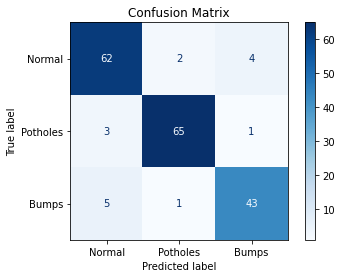

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

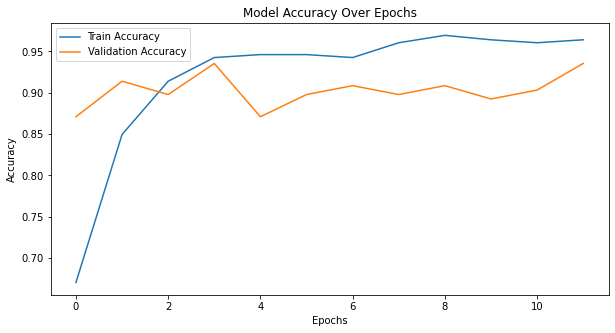

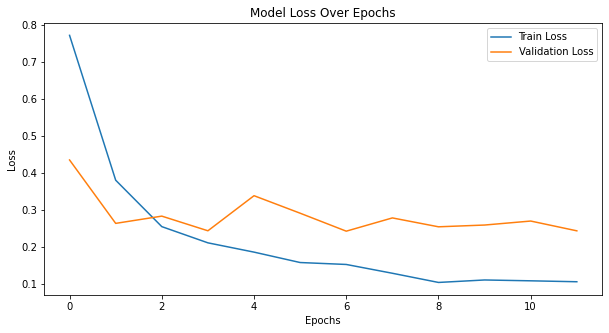

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **ResNet50V2**

In [ ]:
base_model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False

94668760/94668760 [==============================] - 546s 6us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(32, activation="relu")(x)
x = Dense(3, activation="softmax")(x)

ResNet50V2_model = Model(inputs=base_model.input, outputs=x)
ResNet50V2_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5)
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = ResNet50V2_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
18/18 [==============================] - 42s 2s/step - loss: 0.7380 - accuracy: 0.6810 - val_loss: 0.2788 - val_accuracy: 0.9355 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 32s 2s/step - loss: 0.2378 - accuracy: 0.9158 - val_loss: 0.1485 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 32s 2s/step - loss: 0.1631 - accuracy: 0.9462 - val_loss: 0.1258 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 32s 2s/step - loss: 0.1206 - accuracy: 0.9570 - val_loss: 0.1274 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 34s 2s/step - loss: 0.1017 - accuracy: 0.9731 - val_loss: 0.1266 - val_accuracy: 0.9516 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 33s 2s/step - loss: 0.0711 - accuracy: 0.9803 - val_loss: 0.1123 - val_accuracy: 0.9624 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 34s 2s/step - loss: 0.0596 - a

In [ ]:
for layer in base_model.layers[-10:]:
    layer.trainable = True

ResNet50V2_model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

ResNet50V2_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/25
18/18 [==============================] - 98s 5s/step - loss: 0.2870 - accuracy: 0.9122 - val_loss: 0.4073 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 2/25
18/18 [==============================] - 78s 4s/step - loss: 0.1635 - accuracy: 0.9391 - val_loss: 0.4107 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 3/25
18/18 [==============================] - 81s 4s/step - loss: 0.0479 - accuracy: 0.9839 - val_loss: 2.7320 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 4/25
18/18 [==============================] - 80s 4s/step - loss: 0.0351 - accuracy: 0.9928 - val_loss: 0.3539 - val_accuracy: 0.9462 - lr: 0.0010
Epoch 5/25
18/18 [==============================] - 78s 4s/step - loss: 0.0270 - accuracy: 0.9875 - val_loss: 0.9093 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 6/25
18/18 [==============================] - 79s 4s/step - loss: 0.0632 - accuracy: 0.9785 - val_loss: 0.8130 - val_accuracy: 0.9032 - lr: 0.0010
Epoch 7/25
18/18 [==============================] - 77s 4s/step - loss: 0.0267 - a

In [ ]:
train_loss, train_accuracy = ResNet50V2_model.evaluate(train_datagen.flow(X_train, y_train))
test_loss, test_accuracy = ResNet50V2_model.evaluate(val_datagen.flow(X_test, y_test))

print(f"Training Accuracy ResNet50V2: {train_accuracy*100:.2f}%")
print(f"Test Accuracy ResNet50V2: {test_accuracy*100:.2f}%")

6/6 [==============================] - 21s 4s/step - loss: 0.4405 - accuracy: 0.9570
Training Accuracy ResNet50V2: 98.75%
Test Accuracy ResNet50V2: 95.70%


In [ ]:
ResNet50V2_model.save("ResNet50V2.keras")

In [ ]:
loaded_model = load_model("ResNet50V2.keras")

In [ ]:
y_pred_probs = loaded_model.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 [==============================] - 29s 3s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.97      0.94        68
    Potholes       0.97      0.99      0.98        69
       Bumps       1.00      0.90      0.95        49

    accuracy                           0.96       186
   macro avg       0.96      0.95      0.96       186
weighted avg       0.96      0.96      0.96       186



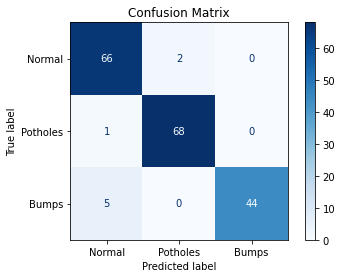

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

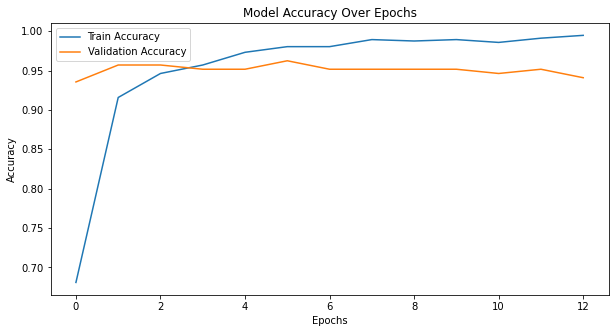

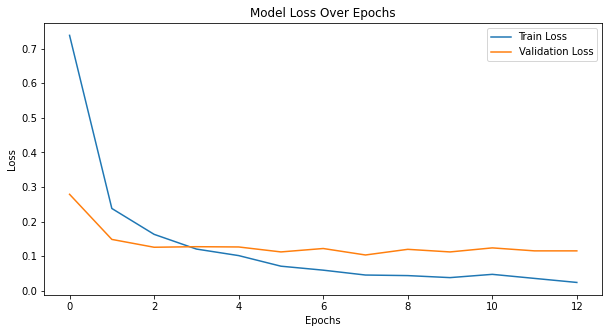

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **InceptionResNetV2**

In [ ]:
num_classes = len(np.unique(np.argmax(y_train, axis=1)))
input_shape = X_train.shape[1:]  
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

In [ ]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
batch_size = 32
epochs = 25

In [ ]:
history_fine_tune = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=val_datagen.flow(X_val,y_val),
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step - accuracy: 0.5097 - loss: 11.0824 - val_accuracy: 0.8280 - val_loss: 2.4330
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.7766 - loss: 3.9962 - val_accuracy: 0.8602 - val_loss: 2.0952
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8005 - loss: 3.2688 - val_accuracy: 0.8817 - val_loss: 1.3491
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8313 - loss: 1.7392 - val_accuracy: 0.8978 - val_loss: 1.0996
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8499 - loss: 1.2367 - val_accuracy: 0.8978 - val_loss: 0.6499
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8526 - loss: 0.7927 - val_accuracy: 0.8978 - val_loss: 0.7239
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8809 - loss: 0.6477 - val_accuracy: 0.8763 - val_loss: 0.6217
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8657 - loss: 0.9754 - val_accuracy: 0.9086 - val_loss

In [ ]:
for layer in base_model.layers[-5:]:
    layer.trainable = True

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history_fine_tune = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=val_datagen.flow(X_val,y_val),
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.7966 - loss: 1.3072 - val_accuracy: 0.8871 - val_loss: 1.2760
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.8221 - loss: 0.7045 - val_accuracy: 0.8925 - val_loss: 0.7184
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8340 - loss: 0.4938 - val_accuracy: 0.8763 - val_loss: 0.3452
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8030 - loss: 0.5947 - val_accuracy: 0.9140 - val_loss: 0.3353
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8158 - loss: 0.4403 - val_accuracy: 0.8925 - val_loss: 0.4067
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8756 - loss: 0.3635 - val_accuracy: 0.9032 - val_loss: 0.4055
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9163 - loss: 0.2287 - val_accuracy: 0.8925 - val_loss: 0.4761
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.8822 - loss: 0.3438 - val_accuracy: 0.8925 - val_loss:

In [ ]:
test_loss, test_accuracy = model.evaluate(val_datagen.flow(X_test, y_test, batch_size=batch_size))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.9638 - loss: 0.1004
Test Loss: 0.10687889903783798
Test Accuracy: 0.9677419066429138


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_resnet_v2 (Functional)     │ (None, 6, 6, 1536)          │      54,336,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 55296)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      14,156,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,166,251 (401.18 MB)

 Trainable params: 18,320,099 (69.89 MB)

 Non-trainable params: 50,205,952 (191.52 MB)

 Optimizer params: 36,640,200 (139.77 MB)

In [ ]:
model.save('InceptionResNetV2_model(.967).keras')

In [ ]:
loaded_modelInceptionResNetV2 = load_model('InceptionResNetV2_model(.967).keras')

In [ ]:
y_pred_probs = loaded_modelInceptionResNetV2.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print("Classification Report InceptionResNetV2:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step
Classification Report InceptionResNetV2:
              precision    recall  f1-score   support

      Normal       0.97      0.94      0.96        68
    Potholes       1.00      0.99      0.99        69
       Bumps       0.92      0.98      0.95        49

    accuracy                           0.97       186
   macro avg       0.96      0.97      0.97       186
weighted avg       0.97      0.97      0.97       186



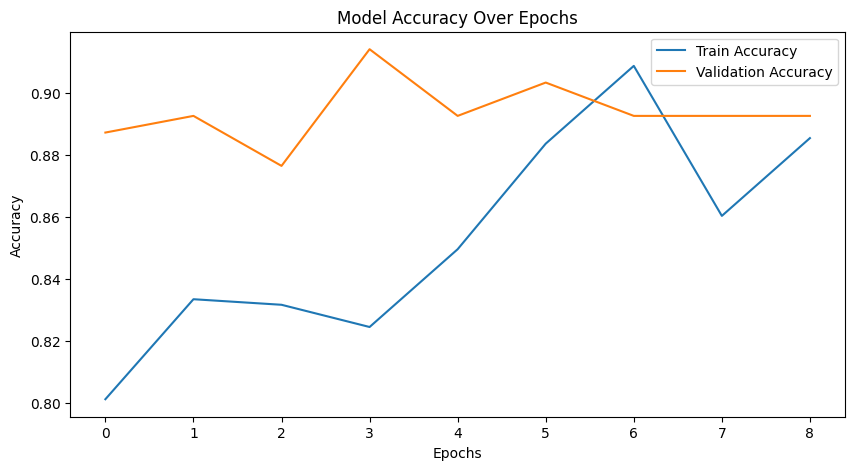

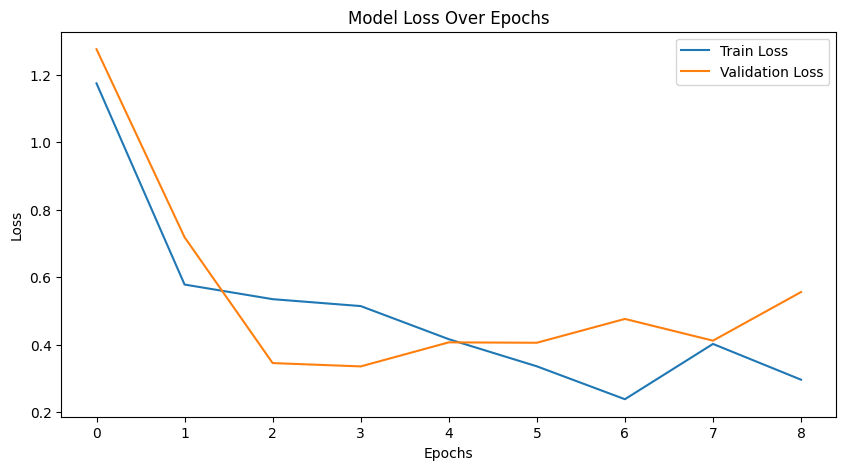

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_fine_tune.history['loss'], label='Train Loss')
plt.plot(history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Hybrid_Model(VGG16 + Transformer)**

In [ ]:
input_shape = (256, 256, 3)
base_model = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')
base_model.trainable = False 

In [ ]:
def transformer_block(input_tensor, num_heads, projection_dim, ff_dim):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(input_tensor, input_tensor)
    attn_output = Add()([attn_output, input_tensor])
    attn_output = LayerNormalization()(attn_output)
    ffn_output = Dense(ff_dim, activation='relu')(attn_output)
    ffn_output = Dense(projection_dim)(ffn_output)
    ffn_output = Add()([ffn_output, attn_output])
    ffn_output = LayerNormalization()(ffn_output)
    return ffn_output


In [ ]:
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
transformer_input = Reshape((16, 16))(x)
x = transformer_block(transformer_input, num_heads=4, projection_dim=16, ff_dim=64)
x = GlobalAveragePooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(3, activation='softmax')(x)

hybrid_model = Model(inputs, outputs)

In [ ]:
hybrid_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = hybrid_model.fit(train_datagen.flow(X_train, y_train, batch_size=32),validation_data=val_datagen.flow(X_val, y_val),
    epochs=25,callbacks=[early_stopping])

Epoch 1/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 282s 16s/step - accuracy: 0.5237 - loss: 1.0066 - val_accuracy: 0.8978 - val_loss: 0.5798
Epoch 2/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 281s 16s/step - accuracy: 0.8421 - loss: 0.6034 - val_accuracy: 0.9140 - val_loss: 0.2958
Epoch 3/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 288s 16s/step - accuracy: 0.8659 - loss: 0.3774 - val_accuracy: 0.9355 - val_loss: 0.2270
Epoch 4/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 323s 18s/step - accuracy: 0.8981 - loss: 0.3047 - val_accuracy: 0.9409 - val_loss: 0.1952
Epoch 5/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 386s 18s/step - accuracy: 0.9159 - loss: 0.2785 - val_accuracy: 0.9140 - val_loss: 0.2150
Epoch 6/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 308s 17s/step - accuracy: 0.9453 - loss: 0.1946 - val_accuracy: 0.8978 - val_loss: 0.2681
Epoch 7/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 309s 17s/step - accuracy: 0.9040 - loss: 0.2607 - val_accuracy: 0.9247 - val_loss: 0.2147
Epoch 8/25
18/18 ━━━━━━━━━━━━━━━━━━━━ 307s 17s/step - accuracy: 0.9264 - loss: 0.2273 - val_accuracy: 0.

In [ ]:
train_loss, train_accuracy = hybrid_model.evaluate(X_train, y_train)
test_loss, test_accuracy = hybrid_model.evaluate(X_test, y_test)

print(f"Training Accuracy (VGG16-Transformer): {train_accuracy * 100:.2f}%")
print(f"Test Accuracy (VGG16-Transformer): {test_accuracy * 100:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 211s 12s/step - accuracy: 0.9833 - loss: 0.0548
6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 11s/step - accuracy: 0.9630 - loss: 0.1225
Training Accuracy (VGG16-Transformer): 98.39%
Test Accuracy (VGG16-Transformer): 95.70%


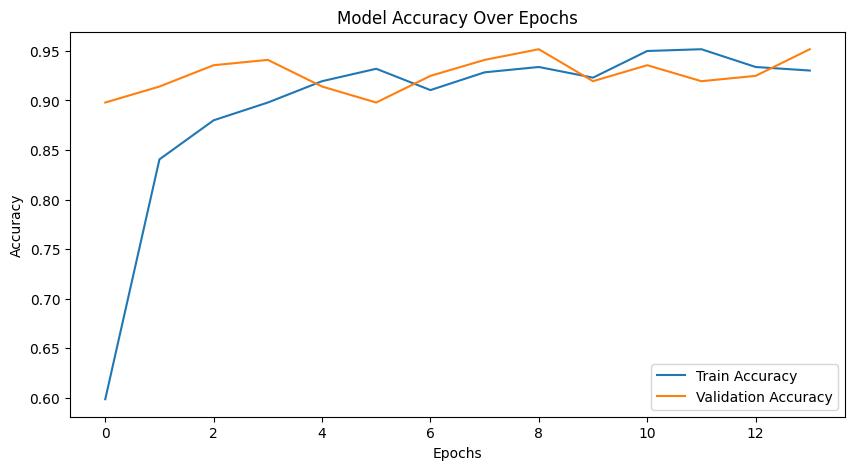

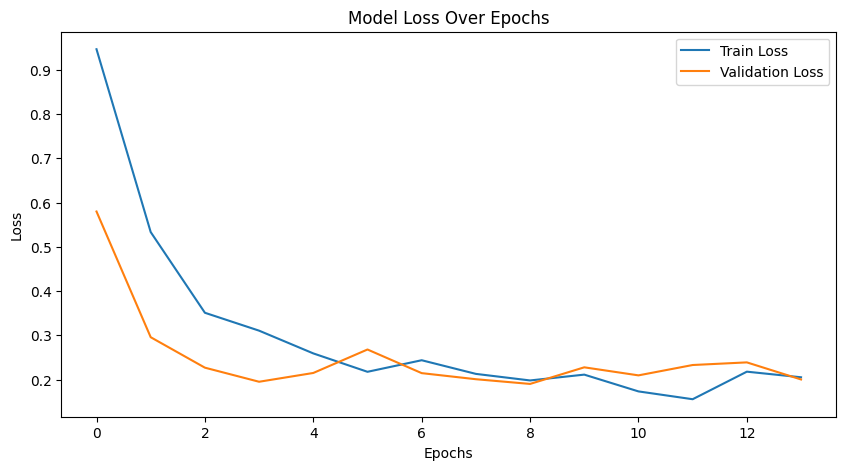

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_save_path = 'VGG16-Transformers-model.h5'
hybrid_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to VGG16-Transformers-model.h5


In [ ]:
loaded_model = load_model('VGG16-Transformers-model.h5')

In [ ]:
y_pred_probs = loaded_model.predict(X_test) 
y_pred_classes = np.argmax(y_pred_probs, axis=1)  
y_true_classes = np.argmax(y_test, axis=1)  

print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=['Normal', 'Potholes', 'Bumps']))

6/6 ━━━━━━━━━━━━━━━━━━━━ 79s 13s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.94      0.94      0.94        68
    Potholes       0.96      0.99      0.97        69
       Bumps       0.98      0.94      0.96        49

    accuracy                           0.96       186
   macro avg       0.96      0.96      0.96       186
weighted avg       0.96      0.96      0.96       186



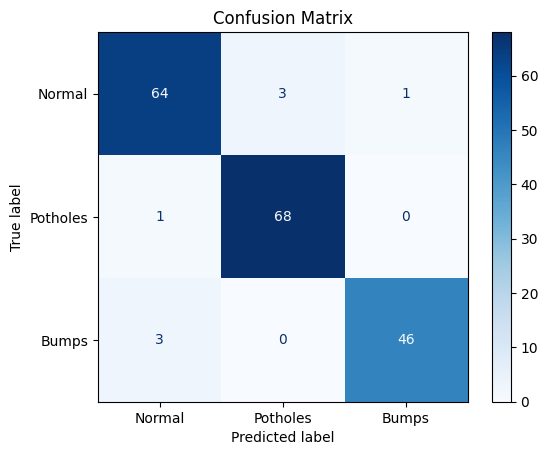

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Potholes', 'Bumps'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## **GUI**

In [2]:
model_path = 'densenet_pothole_detection_model.h5'
model = tf.keras.models.load_model(model_path)
class_labels = ['Normal', 'Potholes', 'Bumps']
def preprocess_image(img):
    img = img.resize((256, 256))  
    img = np.array(img) / 255.0  
    img = np.expand_dims(img, axis=0) 
    return img

def predict(image_input):
    img = preprocess_image(image_input)
    prediction = model.predict(img)
    predicted_class = np.argmax(prediction, axis=1)
    return class_labels[predicted_class[0]], float(prediction[0][predicted_class[0]])

iface = gr.Interface(
    fn=predict,  
    inputs=gr.Image(type="pil"),  
    outputs=[gr.Label(num_top_classes=3), gr.Textbox(label="Confidence")],  
    live=True,  
    title="Pothole Detection",  
    description="Upload an image to classify whether it contains Normal road, Potholes, or Bumps.",
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


Traceback (most recent call last):
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 2047, in process_api
    result = await self.call_function(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1594, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Py

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 995ms/step


Traceback (most recent call last):
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 2047, in process_api
    result = await self.call_function(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\gradio\blocks.py", line 1594, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "c:\Users\hamad\AppData\Local\Programs\Python\Python310\lib\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "c:\Users\hamad\AppData\Local\Programs\Python\Py

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
